## Import libraries

In [1]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# import os
# os.environ["CUDA_DIR"] = "/home/tuk/anaconda3/pkgs/cuda-nvcc-11.6.124-hbba6d2d_0/nvvm"
# !echo ${CUDA_DIR}\

# print(tf.sysconfig.get_build_info() )

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# !pip install protobuf~=3.20.3
# !pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text tensorflow

# !pip install transformers
# !pip install datasets

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import transformers
import datasets

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

/home/tuk/anaconda3/envs/trans/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-01-25 11:33:59.127021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:33:59.127050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:33:59.127867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:33:59.132693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 11:33:59.891419: W tensorflow/compiler/tf2

## Load dataset

In [4]:
examples, metadata = tfds.load('huggingface:opus_books/en-fr',
                               with_info=True)

/home/tuk/anaconda3/envs/trans/lib/python3.11/site-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:160: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-01-25 11:34:47.459143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 11:34:47.490137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024

In [5]:
examples = examples['train']
print(examples)

<_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'translation': {'en': TensorSpec(shape=(), dtype=tf.string, name=None), 'fr': TensorSpec(shape=(), dtype=tf.string, name=None)}}>


## Make train test splits

In [6]:
# Get the total number of examples
total_examples = metadata.splits['train'].num_examples

# Define the split ratios (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1.0 - train_ratio

# Calculate the number of examples for each split
train_size = int(train_ratio * total_examples)
print(train_size, total_examples)

# Split the dataset into train and test dictionaries
train_examples = list(examples)[:train_size]
test_examples = list(examples)[train_size:]

# # HARD CODING
# # Split the dataset into train and test dictionaries
# train_examples = list(examples)[:10000]
# test_examples = list(examples)[10000:13000]

101668 127085


In [7]:
# Print lengths
print(len(train_examples))
print(len(test_examples))

101668
25417


## Process dataset for training the tensorflow model

In [8]:
formatted_train_examples = []  # list of tuples
formatted_test_examples = []  # list of tuples
for record in train_examples:
    formatted_train_examples.append(
        (record['translation']['fr'].numpy(), record['translation']['en'].numpy()))

for record in test_examples:
    formatted_test_examples.append(
        (record['translation']['fr'].numpy(), record['translation']['en'].numpy()))

In [9]:
# Separate the pairs into two lists
fr_train_list, en_train_list = zip(*formatted_train_examples)
fr_test_list, en_test_list = zip(*formatted_test_examples)

In [10]:
# Create TensorFlow tensors from the values
fr_train_tensor = tf.stack(fr_train_list)
en_train_tensor = tf.stack(en_train_list)
fr_test_tensor = tf.stack(fr_test_list)
en_test_tensor = tf.stack(en_test_list)

In [11]:
# Create a dataset from the tensors
train_dataset = tf.data.Dataset.from_tensor_slices((fr_train_tensor, en_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((fr_test_tensor, en_test_tensor))

# Prefetch the datasets for better performance
train_examples = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_examples = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
for fr_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in French:')
  for fr in fr_examples.numpy():
    print(fr.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in French:
Le grand Meaulnes
Alain-Fournier
PREMIÈRE PARTIE

> Examples in English:
The Wanderer
Alain-Fournier
First Part


## Tokenize the data

In [13]:
# Convert tensors to numpy arrays
fr_train_array = fr_train_tensor.numpy()
en_train_array = en_train_tensor.numpy()
fr_test_array = fr_test_tensor.numpy()
en_test_array = en_test_tensor.numpy()

# Convert numpy arrays to lists of strings
fr_train_texts = ['START ' + fr.decode('utf-8') + ' END' for fr in fr_train_array]
en_train_texts = ['START ' + en.decode('utf-8') + ' END' for en in en_train_array]
fr_test_texts = ['START ' + fr.decode('utf-8') + ' END' for fr in fr_test_array]
en_test_texts = ['START ' + en.decode('utf-8') + ' END' for en in en_test_array]

# Tokenizer for English
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
en_tokenizer.fit_on_texts(en_train_texts)

# Tokenizer for French
fr_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
fr_tokenizer.fit_on_texts(fr_train_texts)

# Tokenize and pad the sequences
en_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    en_tokenizer.texts_to_sequences(en_train_texts),
    padding='post'
)
fr_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    fr_tokenizer.texts_to_sequences(fr_train_texts),
    padding='post'
)
en_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    en_tokenizer.texts_to_sequences(en_test_texts),
    padding='post'
)
fr_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    fr_tokenizer.texts_to_sequences(fr_test_texts),
    padding='post'
)

In [14]:
en_vocab_size = vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = vocab_size = len(fr_tokenizer.word_index) + 1

print('English vocabulary size:', en_vocab_size)
print('French vocabulary size:', fr_vocab_size)

English vocabulary size: 126355
French vocabulary size: 142530


In [15]:
en = en_train_sequences[0]
fr = fr_train_sequences[0]
en

array([    3,     1, 18209,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [16]:
# Print the tokenized sequences
print("Tokenized English training sequences:")
for seq in en_train_sequences:
    print(seq)
    break

print("\nTokenized French training sequences:")
for seq in fr_train_sequences:
    print(seq)
    break

print("\nTokenized English test sequences:")
for seq in en_test_sequences:
    print(seq)
    break

print("\nTokenized French test sequences:")
for seq in fr_test_sequences:
    print(seq)
    break


Tokenized English training sequences:
[    3     1 18209     2     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0 

In [17]:
# Set batch size
batch_size = 32

# Create TensorFlow datasets for training and testing with batching
train_dataset = tf.data.Dataset.from_tensor_slices(((fr_train_sequences, en_train_sequences[:, :-1]), en_train_sequences[:, 1:]))
train_dataset = train_dataset.shuffle(buffer_size=len(fr_train_sequences)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((fr_test_sequences, en_test_sequences[:, :-1]), en_test_sequences[:, 1:]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Print the first example from the training dataset
for (fr, en), en_label in train_dataset.take(1):
    print("Example Input (French):", fr.shape)
    print("Example Input (English - Input):", en.shape)
    print("Example Label (English - Output):", en_label.shape)

Example Input (French): (32, 326)
Example Input (English - Input): (32, 373)
Example Label (English - Output): (32, 373)


## Model

In [18]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

positional_encoding(4, 2).shape

TensorShape([4, 2])

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]  # No of words
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # x *= tf.pow(self.d_model, tf.constant(0.5, dtype=tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [20]:
embed_fr = PositionalEmbedding(vocab_size=fr_vocab_size, d_model=512)
embed_en = PositionalEmbedding(vocab_size=en_vocab_size, d_model=512)

fr = tf.stack(fr_train_sequences[0:2])
en = tf.stack(en_train_sequences[0:2])

In [21]:
print('French input shape:', fr.shape)
fr_emb = embed_fr(fr)
print(fr_emb.shape)

print('English input shape:', en.shape)
en_emb = embed_en(en)
print(en_emb.shape)

French input shape: (2, 326)
(2, 326, 512)
English input shape: (2, 374)
(2, 374, 512)


2024-01-25 11:35:21.487980: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:21.489003: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-25 11:35:21.489017: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-01-25 11:35:21.489056: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [22]:
en_emb._keras_mask

<tf.Tensor: shape=(2, 374), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, F

In [23]:
# MultiHeadAttention Layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.dropout = dropout

        assert key_dim % num_heads == 0

        self.depth = key_dim // num_heads

        self.query_dense = tf.keras.layers.Dense(key_dim)
        self.key_dense = tf.keras.layers.Dense(key_dim)
        self.value_dense = tf.keras.layers.Dense(key_dim)

        self.dense = tf.keras.layers.Dense(key_dim)

    def _masked_softmax(self, attention_scores, attention_mask):
        """Computes a softmax with explicit padding.

        Args:
            attention_scores: A tensor with shape [batch_size, num_heads,
                query_seq_length, memory_seq_length]
            attention_mask: A tensor with shape [batch_size, 1, query_seq_length,
                memory_seq_length], the original attention mask.

        Returns:
            attention_probs: A tensor with shape [batch_size, num_heads,
                query_seq_length, memory_seq_length], the new attention mask.
        """
        # Normalize the attention scores to probabilities.
        # `attention_scores` = [B, N, T, S]
        attention_mask = tf.expand_dims(
            attention_mask, axis=1
        )

        # Add a large negative value to masked positions to make their attention scores close to zero
        attention_scores = attention_scores + (1.0 - tf.cast(attention_mask, tf.float32)) * -1e9

        # Calculate softmax along the last dimension (memory_seq_length)
        attention_probs = tf.nn.softmax(attention_scores, axis=-1)

        return attention_probs

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        attention_weights = self._masked_softmax(scaled_attention_logits, mask)
        output = tf.matmul(attention_weights, v)

        return output, attention_weights


    def call(self, query, key, value, use_causal_mask=False):
        batch_size = tf.shape(query)[0]

        mask = self._compute_attention_mask(query, value, key, use_causal_mask=use_causal_mask)

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)

        return output, attention_weights

    def _compute_attention_mask(
        self, query, value, key=None, attention_mask=None, use_causal_mask=False
    ):
        """ Computes the attention mask, using the Keras masks of the inputs. """
        query_mask = getattr(query, "_keras_mask", None)
        value_mask = getattr(value, "_keras_mask", None)
        key_mask = getattr(key, "_keras_mask", None)
        auto_mask = None
        if query_mask is not None:
            query_mask = tf.cast(query_mask, tf.bool)  # defensive casting
            # B = batch size, T = max query length
            auto_mask = query_mask[:, :, tf.newaxis]  # shape is [B, T, 1]
        if value_mask is not None:
            value_mask = tf.cast(value_mask, tf.bool)  # defensive casting
            # B = batch size, S == max value length
            mask = value_mask[:, tf.newaxis, :]  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if key_mask is not None:
            key_mask = tf.cast(key_mask, tf.bool)  # defensive casting
            # B == batch size, S == max key length == max value length
            mask = key_mask[:, tf.newaxis, :]  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if use_causal_mask:
            # the shape of the causal mask is [1, T, S]
            mask = self._compute_causal_mask(query, value)
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if auto_mask is not None:
            # merge attention_mask & automatic mask, to shape [B, T, S]
            attention_mask = (
                auto_mask
                if attention_mask is None
                else tf.cast(attention_mask, bool) & auto_mask
            )
        return attention_mask

    def _compute_causal_mask(self, query, value=None):
        """ Computes the causal attention mask. """

        q_seq_length = tf.shape(query)[1]
        v_seq_length = q_seq_length if value is None else tf.shape(value)[1]
        return tf.linalg.band_part(  # creates a lower triangular matrix
            tf.ones((1, q_seq_length, v_seq_length), tf.bool), -1, 0
    )

In [24]:
# All its child layers need num_heads and key_dim(or dmodel) for initialization
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [25]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(fr_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, fr_emb).shape)

(2, 326, 512)
(2, 374, 512)


2024-01-25 11:35:21.633268: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:21.633349: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:21.633391: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:21.633626: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

(2, 374, 512)


2024-01-25 11:35:21.836600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


In [27]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [28]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(fr_emb.shape)
print(sample_gsa(fr_emb).shape)

(2, 326, 512)
(2, 326, 512)


In [29]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [30]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
print(en_emb.shape)
print(sample_csa(en_emb).shape)

(2, 374, 512)
(2, 374, 512)


In [31]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

0.00062036514

In [32]:
# This layer needs dmodel and dff for initialization
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [33]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(2, 374, 512)


(2, 374, 512)


2024-01-25 11:35:22.068679: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:22.069929: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [35]:
sample_enc_layer = EncoderLayer(d_model=512, num_heads=4, dff=2048, dropout_rate=0.1)

print(fr_emb.shape)
print(sample_enc_layer(fr_emb).shape)

(2, 326, 512)
(2, 326, 512)


In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [37]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=fr_vocab_size)

sample_encoder_output = sample_encoder(fr, training=False)

# Print the shape.
print(fr.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(2, 326)
(2, 326, 512)


In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [39]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=fr_emb
)

print(sample_decoder_layer_output.shape)

(2, 374, 512)


In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [41]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=en_vocab_size)

output = sample_decoder(
    x=en,
    context=fr_emb)

# Print the shapes.
print(en.shape)
print(fr_emb.shape)
print(output.shape)

(2, 374)
(2, 326, 512)
(2, 374, 512)


In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [43]:
num_layers = 4
d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.3

In [44]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=fr_vocab_size,
    target_vocab_size=en_vocab_size,
    dropout_rate=dropout_rate)

In [45]:
output = transformer((fr, en))

print(en.shape)
print(fr.shape)
print(output.shape)

(2, 374)
(2, 326)
(2, 374, 126355)


In [46]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(2, 8, 374, 326)


In [47]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  38596096  
                                                                 
 decoder_1 (Decoder)         multiple                  35510016  
                                                                 
 dense_158 (Dense)           multiple                  32473235  
                                                                 
Total params: 106579347 (406.57 MB)
Trainable params: 106579347 (406.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [49]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

2024-01-25 11:35:23.644524: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:23.645844: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 11:35:23.725970: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:23.726056: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

Text(0.5, 0, 'Train Step')

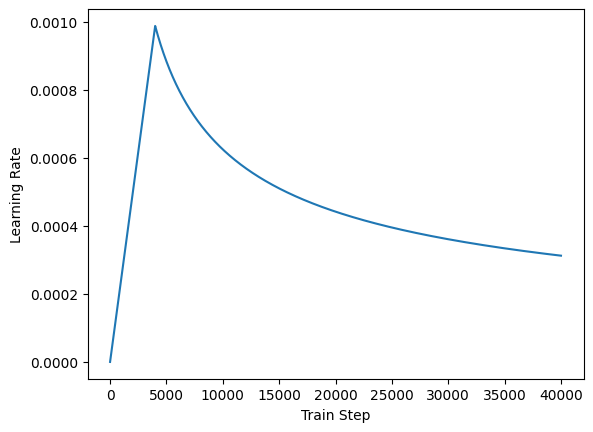

In [50]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [51]:
def masked_loss(label, pred):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  mask = label!=0
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  mask = label!=0
  match = label==pred
  match  = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [52]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [53]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [54]:
transformer.fit(train_dataset,
                epochs=100,
                validation_data=test_dataset)

Epoch 1/100


2024-01-25 11:35:42.500000: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:42.501477: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 11:35:42.636966: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-25 11:35:42.640095: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

   1/3178 [..............................] - ETA: 23:45:14 - loss: 11.7465 - masked_accuracy: 0.0000e+00

2024-01-25 11:35:51.042658: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



3178/3178 [==============================] - 2078s 646ms/step - loss: 7.0842 - masked_accuracy: 0.1247 - val_loss: 5.9774 - val_masked_accuracy: 0.1912
Epoch 2/100
3178/3178 [==============================] - 2038s 641ms/step - loss: 5.9765 - masked_accuracy: 0.1851 - val_loss: 5.7046 - val_masked_accuracy: 0.2110
Epoch 3/100
1854/3178 [================>.............] - ETA: 12:50 - loss: 5.6836 - masked_accuracy: 0.2053

## Translator

In [ ]:
def print_translation(sentence, text, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {text}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
# Get the token for 'Start'
start_token = en_tokenizer.word_index['start']
start_token = tf.constant(start_token, dtype=tf.int64)

# Get the token for 'End'
end_token = en_tokenizer.word_index['end']
end_token = tf.constant(end_token, dtype=tf.int64)

print("Token for 'Start':", start_token)
print("Token for 'End':", end_token)

Token for 'Start': tf.Tensor(3, shape=(), dtype=int64)
Token for 'End': tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
class Translator(tf.Module):
  def __init__(self, en_tokenizer, fr_tokenizer, transformer):
    self.en_tokenizer = en_tokenizer
    self.fr_tokenizer = fr_tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=206):

    encoder_input = sentence  # (1, 11)
    start = start_token  # shape=(1,)
    end = end_token  # shape=(1,)

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())  # (1, X)
      output = tf.expand_dims(output, 0)
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0][0])  # Writing a tensor of shape 1

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    # text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    # tokens = tokenizers.en.lookup(output)[0]
    text = en_tokenizer.sequences_to_texts([output.numpy()])[0]
    # text = text.split(' ')[1:-1]
    # text = ' '.join(text)

    return text

translator = Translator(en_tokenizer, fr_tokenizer, transformer)

In [ ]:
sentence = 'PREMIÈRE PARTIE'
ground_truth = 'First Part'

# sentence = 'Le grand Meaulnes'
# ground_truth = 'The Wanderer'

# sentence = 'Alain-Fournier'
# ground_truth = 'Alain-Fournier'

# Tokenize the sentences using the tokenizers
encoded_sentence = tf.keras.preprocessing.sequence.pad_sequences(fr_tokenizer.texts_to_sequences([sentence]), padding='post')
encoded_ground_truth = tf.keras.preprocessing.sequence.pad_sequences(en_tokenizer.texts_to_sequences([ground_truth]), padding='post')

# Print the encoded sequences
# print("Encoded Sentence:")
# print(encoded_sentence)
# print("\nEncoded Ground Truth:")
# print(encoded_ground_truth)

translated_text = translator(encoded_sentence, max_length=2)
print_translation(sentence, translated_text, ground_truth)

Input:         : PREMIÈRE PARTIE
Prediction     : start first part
Ground truth   : First Part


> Examples in French:

    Le grand Meaulnes
    Alain-Fournier
    PREMIÈRE PARTIE

> Examples in English:

    The Wanderer
    Alain-Fournier
    First Part

# Evaluation

In [ ]:
references_list = [['are', 'you', 'fond', 'of', 'and', 'he', 'searched',
   'my', 'face', 'with', 'eyes', 'that', 'i', 'saw', 'were',
     'dark,', 'and', 'end']]

hypothesis = ['start', 'they', 'were', 'waiting', 'for', 'a', 'disposition',
               'of', 'the', 'house;', 'and', 'one', 'hand', 'passed', 'her',
                 'windows', 'in', 'the', 'did', 'not', 'dwell', 'on', 'the', 
                 'should', 'quit', 'garden', 'gardiner,', 'whose', 'bright', 
                 'church', 'bright', '.', '.', ".'", 'end']

# # Reference and hypothesis sentences
# references_list = [['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'for']]
# hypothesis = ['the', 'fast', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'the', 'lazy', 'dog']

# Compute BLEU score for a single sentence
bleu_score = corpus_bleu([references_list], [hypothesis], weights=(1, 0, 0, 0))
print(f'BLEU Score: {bleu_score}')


BLEU Score: 0.11428571428571427


In [ ]:
# Reference and hypothesis sentences for multiple examples
# DOES NOT WORK
references = [
    ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'],
    ['the', 'cat', 'in', 'the', 'hat']
]

hypotheses = [
    ['the', 'fast', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'],
    ['a', 'cat', 'in', 'a', 'hat']
]

# Compute BLEU score for multiple sentences
bleu_score = corpus_bleu(references, hypotheses)
print(f'BLEU Score: {bleu_score}')


BLEU Score: 9.418382295637229e-232


### Evaluation of bleu score on train data

In [ ]:
import warnings
# Disable specific warnings
warnings.simplefilter("ignore", UserWarning)

def calculate_bleu_score(translator, train_dataset, max_length=206):
    overall_bleu_score = 0.0
    count = 0

    # Use tqdm for progress bar
    pbar = tqdm(train_dataset, desc="Calculating BLEU Score")

    for (fr, en), en_label in pbar:
        for i in range(fr.shape[0]):
            fr_sentence = fr[i:i+1, :]
            en_label_sentence = en_label[i:i+1, :]
            ground_truth = en_tokenizer.sequences_to_texts(en_label_sentence.numpy())[0]
            # ground_truth = ground_truth.split(' ')[1:-1]
            # ground_truth = ' '.join(ground_truth)
            
            translated_text = translator(fr_sentence, max_length)
            
            # Bleu score evaluation
            references = []
            references.append(ground_truth.split(' '))
            translated_text = translated_text.split(' ')
            overall_bleu_score += corpus_bleu([references], [translated_text], weights=(1, 0, 0, 0))
            count += 1

        # Display progress in tqdm
        pbar.set_postfix({'Bleu Score': overall_bleu_score/count})

    return overall_bleu_score/count

bleu_score = calculate_bleu_score(translator, train_dataset)
print("BLEU Score on train Dataset:", bleu_score)


Calculating BLEU Score:   0%|          | 0/313 [00:00<?, ?it/s]

0.9230769230769231
0.8782051282051282
0.891025641025641
0.8932692307692307


Calculating BLEU Score:   0%|          | 0/313 [00:07<?, ?it/s]


KeyboardInterrupt: 

### Evaluation of bleu score on test data

In [ ]:
import warnings
# Disable specific warnings
warnings.simplefilter("ignore", UserWarning)

def calculate_bleu_score(translator, test_dataset, max_length=206):
    overall_bleu_score = 0.0
    count = 0

    # Use tqdm for progress bar
    pbar = tqdm(test_dataset, desc="Calculating BLEU Score")

    for (fr, en), en_label in pbar:
        for i in range(fr.shape[0]):
            fr_sentence = fr[i:i+1, :]
            en_label_sentence = en_label[i:i+1, :]
            ground_truth = en_tokenizer.sequences_to_texts(en_label_sentence.numpy())[0]
            # ground_truth = ground_truth.split(' ')[1:-1]
            # ground_truth = ' '.join(ground_truth)
            
            translated_text = translator(fr_sentence, max_length)
            
            # Bleu score evaluation
            references = []
            references.append(ground_truth.split(' '))
            translated_text = translated_text.split(' ')
            overall_bleu_score += corpus_bleu([references], [translated_text], weights=(1, 0, 0, 0))
            count += 1

        # Display progress in tqdm
        pbar.set_postfix({'Bleu Score': overall_bleu_score/count})

    return overall_bleu_score/count

bleu_score = calculate_bleu_score(translator, test_dataset)
print("BLEU Score on Test Dataset:", bleu_score)


Calculating BLEU Score:   3%|▎         | 3/94 [07:25<3:45:26, 148.65s/it, Bleu Score=0.192]


KeyboardInterrupt: 